# Total Chi2 for linear fit.

This simple notebook illustrates the importance of fitting for the true "x" parameter while probing the linear `y=ax+b` relation if y and x are noisy.

***
## Simple simulation

*For simplicity, simulations are made with `numpy`. You may consider using `jax.random` instead.*

In [1]:
import numpy as np

# ------------- #
# Problem set   #
# ------------- #
# number of measurements
size = 1000

# parameters to recover
A = 1.5
B = -0.8

# amplitude of gaussian measurement errors
x_err = 0.1
y_err = 0.2

# ------------- #
# modelisation  #
# ------------- #

# This is the true x parameter (i.e., noise free)
x_true = np.random.uniform(0, 2, size)

# y is related to the true parameter 
y_true = x_true * A + B

# now, both are noisy, so
x = x_true + np.random.normal(size=size, loc=0, scale=x_err)
y = y_true + np.random.normal(size=size, loc=0, scale=y_err)


Let's see how it looks

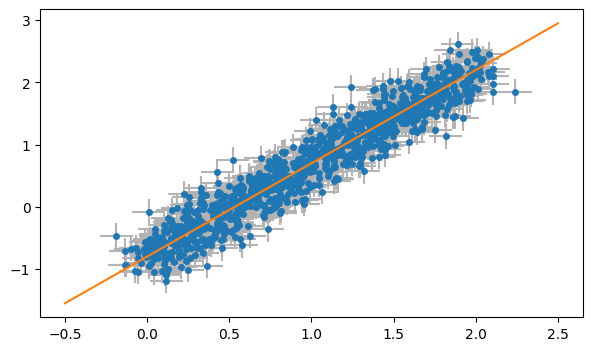

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,4))

# simulated data
ax.errorbar(x, y, xerr=x_err, yerr=y_err, 
            ms=4,
            marker="o", ls="None", ecolor="0.7", 
            zorder=5)
# model
xx = np.linspace(-0.5, 2.5)
ax.plot(xx, xx*A + B, zorder=8)


***
## Basic chi2 fit

We are going to do a simple chi2 fit as it is usually done. It ignores x-err. 
You will see that best fitted *a* and *b* are biased. 

Remark that it exists ways to convert x-err into y-err assuming A and B. But one can show this too is biased. This is not implemented in this example.

In [3]:
# names are changed on purpose to avoid confusions
def get_chi2(params, x_data, y_data, yerr):
    """ """
    a_fit, b_fit = params
    y_model = x_data * a_fit + b_fit
    chi2_per_element = (y_data - y_model)**2 /  yerr**2
    return np.sum(chi2_per_element)

In [4]:
from scipy.optimize import minimize
from scipy import stats

In [5]:
# guess parameters
x0 = (0., 0)

# let's fit using minimize
out = minimize(get_chi2, x0, args=(x, y, y_err))

In [6]:
bestfit = out.x
# ignoring covariance
bestfit_err = np.sqrt( np.diag(out.hess_inv) )
bestfit

array([ 1.46129509, -0.75996813])

Let's see how it looks

(0.0, 46.81115099854124)

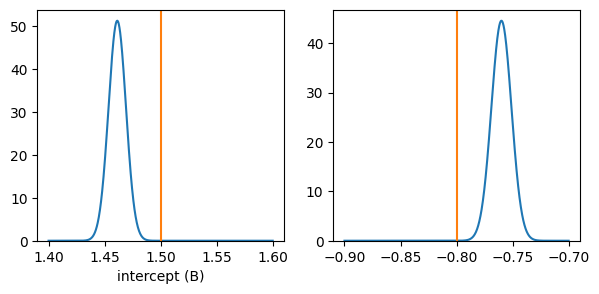

In [7]:
fig, (axa, axb) = plt.subplots(ncols=2, figsize=(7,3))

aa = np.linspace(1.4, 1.6, 1000)
axa.plot(aa, stats.norm.pdf(aa, loc=bestfit[0], scale=bestfit_err[0]))
axa.axvline(A, color="tab:orange")
axa.set_xlabel("slope (A)")

bb = np.linspace(-0.9, -0.7, 1000)
axb.plot(bb, stats.norm.pdf(bb, loc=bestfit[1], scale=bestfit_err[1]))
axb.axvline(B, color="tab:orange")
axa.set_xlabel("intercept (B)")

axa.set_ylim(0)
axb.set_ylim(0)

Fitted parameters is significantly close to 0 (in both cases) than true data.

Let's script to see if we were unlucky

*** 
## Simulation->fit script

In [8]:
def get_simulated_data(size=1000, A=1.5, B=-0.8, x_err = 0.1, y_err = 0.2):
    """ get a simulated data

    Parameters
    ----------
    size: int
        number of point in the simulation

    A, B: float
        linear relation parameters such that y=A*x + b

    x_err, y_err: float, array
        error on observed parameters (must broadcast with size).

    Returns
    -------
    (x, y), (x_true, y_true)
        observed and true parameters (you never have access to in real observations)
    """
    import numpy as np
    # ------------- #
    # modelisation  #
    # ------------- #
    # This is the true x parameter (i.e., noise free)
    x_true = np.random.uniform(0, 2, size)
    
    # y is related to the true parameter 
    y_true = x_true * A + B
    
    # now, both are noisy, so
    x = x_true + np.random.normal(size=size, loc=0, scale=x_err)
    y = y_true + np.random.normal(size=size, loc=0, scale=y_err)
    return (x, y), (x_true, y_true) 

Let's create 400 simulations and grab the bestfit each time

In [9]:
bestfit = []
# parameter of the simulation 
x_err, y_err = 0.1 , 0.2
A, B = 1.5, -0.8
x0 = (1., 0)
for _ in range(400):
    (xmock, ymock), _ = get_simulated_data(size=1000, A=A, B=B, x_err=x_err, y_err=y_err)
    out = minimize(get_chi2, x0, args=(xmock, ymock, y_err))
    bestfit.append(out.x)

And now let's have a look at the best fit distribution

In [10]:
bestfit_a, bestfit_b = np.stack(bestfit).T

(0.0, 107.1)

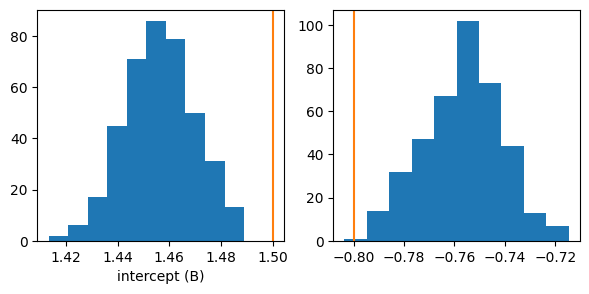

In [11]:
fig, (axa, axb) = plt.subplots(ncols=2, figsize=(7,3))

axa.hist(bestfit_a)
axa.axvline(A, color="tab:orange")
axa.set_xlabel("slope (A)")

axb.hist(bestfit_b)
axb.axvline(B, color="tab:orange")
axa.set_xlabel("intercept (B)")

axa.set_ylim(0)
axb.set_ylim(0)

Same thing... So indeed it is biased

***
## Total Chi2 and unbiased parameters

The solution to this problem is to fit for x_true in addition to A and B. Hence there is now `size+2` parameters to fit !

Fortunatly, [jax](https://github.com/jax-ml/jax) make this easy for you (see e.g. [jax autodiff cookbook](https://docs.jax.dev/en/latest/notebooks/autodiff_cookbook.html))

In [12]:
# Notice the difference with get_chi2:
# - xerr is now an input
# - params is a dict (called a pytree in jax environment). 
#   you don't have too but it makes things simpler to read.
# - y_model is derived from x_true_fit
# - x_true_fit is constrained by x_data given xerr
# - chi2 is the sum of chi2 on x *and* on y 
def get_totalchi2(params, x_data, y_data, xerr, yerr):
    """ """
    # parse the input
    a_fit, b_fit,  = params["coefs"]
    x_true_fit = params["xtrue"]

    # y_model from x_true_fit
    y_model = x_true_fit * a_fit + b_fit

    # leading to the usual chi2 on y
    chi2_per_element__y = (y_data - y_model)**2 /  yerr**2
    
    # x_true_fit constrained by x_data given x_err
    chi2_per_element__x = (x_data - x_true_fit)**2 /  xerr**2

    # chi2 is the sum of both
    chi2_per_element = chi2_per_element__y + chi2_per_element__x
    # 0.5 since sum(chi_y) + sum(chi_y) ~ ndof+ndof
    return 0.5*np.sum(chi2_per_element) 

For the minimisation, we use the classical adam gradiant descent made easy in jax by [optax](https://optax.readthedocs.io/en/latest/).

**careful** we suggest not to use `jax.scipy.optimize.minimize` but dedicated jax-ecosystem gradiant descent e.g. from optax

In [13]:
import jax
import jax.numpy as jnp

### simulate data

In [14]:
x_err, y_err = 0.1 , 0.2
A, B = 1.5, -0.8
(xmock, ymock), _ = get_simulated_data(size=1000, A=A, B=B, x_err=x_err, y_err=y_err)

make then jax array inplace of numpy array (not mandatory but cleaner otherwise the jax will do it directly)

In [15]:
xmock = jnp.asarray(xmock)
ymock = jnp.asarray(ymock)

### let's define the first guess. 

`get_totalchi2` expects a dict (*see code*).


We will use xmock as first guess for x_true, it should not be too far..

In [16]:
x0 = (1., 0) # as before
param_init = {"coefs": jnp.asarray(x0, dtype="float32"),
              "xtrue": xmock.copy()}
            

In [17]:
import optax
learning_rate = 5e-3 # small => slow | high => may miss the minimum
niter = 3_000 # number of iteration for the gradiant descent.
tol = 1e-2 # or stop when you do not progress more than this.

function_input = {"x_data":xmock, 
                  "y_data":ymock, 
                  "xerr": x_err, 
                  "yerr": y_err}

# Initialize the adam optimizer
params = param_init
optimizer = optax.adam(learning_rate)

# Obtain the `opt_state` that contains statistics for the optimizer.
opt_state = optimizer.init(params)

# magic of jax ! here is hte gradiant function
grad_func = jax.jit(jax.grad( get_totalchi2 )) 

# let's store the loss to see.
losses = []
for i in range(niter):
    current_grads = grad_func(params, **function_input)
    updates, opt_state = optimizer.update(current_grads, opt_state)
    params = optax.apply_updates(params, updates)
    losses.append( get_totalchi2(params, **function_input) ) # store the loss function
    if tol is not None and (i>2 and ((losses[-2] - losses[-1]) < tol)):
        break

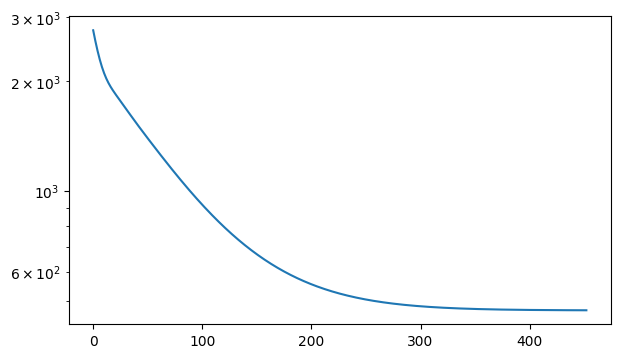

In [18]:
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(losses)
ax.set_yscale("log")

let's see the coefs we got:

In [19]:
params["coefs"]

Array([ 1.49873   , -0.79011863], dtype=float32)

not bad !

### Let's rebuild the hessian from pytrees

In [20]:
hess_pytree = jax.hessian(get_totalchi2)(params, **function_input)

In [21]:
# [   2, 2][   2, 1000]
# [1000, 2][1000, 1000]
ccxc = jnp.vstack([hess_pytree["coefs"]["coefs"] , hess_pytree["xtrue"]["coefs"]])
cxxx = jnp.vstack([hess_pytree["coefs"]["xtrue"], hess_pytree["xtrue"]["xtrue"]])
hess = jnp.hstack([ccxc, cxxx])
cov = jnp.linalg.inv(hess)
a_err, b_err = jnp.stack(jnp.sqrt(jnp.diag(cov)[:2]))

***
## Let's script that to see

In [22]:
def fit_adam(func_, 
             xmock, ymock, x_err, y_err, x0=(1., 0), 
            learning_rate = 5e-3, niter = 3_000,
            tol = 1e-3):
    """ """
    import optax
    # let's make sure they are jax array
    xmock = jnp.asarray(xmock)
    ymock = jnp.asarray(ymock)
    
    
    function_input = {"x_data":xmock, 
                      "y_data":ymock, 
                      "xerr": x_err, 
                      "yerr": y_err}
    
    # initial guess
    param_init = {"coefs": jnp.asarray(x0, dtype="float32"),
              "xtrue": xmock.copy()}
            
    
    # Initialize the adam optimizer
    params = param_init
    optimizer = optax.adam(learning_rate)
    
    # Obtain the `opt_state` that contains statistics for the optimizer.
    opt_state = optimizer.init(params)
    
    # magic of jax ! here is hte gradiant function
    grad_func = jax.jit(jax.grad( func_ )) 
    
    # let's store the loss to see.
    losses = []
    for i in range(niter):
        current_grads = grad_func(params, **function_input)
        updates, opt_state = optimizer.update(current_grads, opt_state)
        params = optax.apply_updates(params, updates)
        losses.append( func_(params, **function_input) ) # store the loss function
        if tol is not None and (i>2 and ((losses[-2] - losses[-1]) < tol)):
            break

    return params, losses

In [23]:
from tqdm import tqdm

bestfit = []
# parameter of the simulation 
x_err, y_err = 0.1 , 0.2
A, B = 1.5, -0.8
x0 = (1., 0)
for _ in tqdm( range(400) ):
    (xmock, ymock), _ = get_simulated_data(size=1000, A=A, B=B, x_err=x_err, y_err=y_err)
    params, losses = fit_adam(func_=get_totalchi2, x0=x0, 
                              xmock=xmock, ymock=ymock, x_err=x_err, y_err=y_err)
    bestfit.append(params["coefs"])

100%|███████████████████████████████████████████████████████████████████████| 400/400 [02:51<00:00,  2.33it/s]


In [24]:
bestfit_a, bestfit_b = jnp.stack(bestfit).T

(0.0, 101.85)

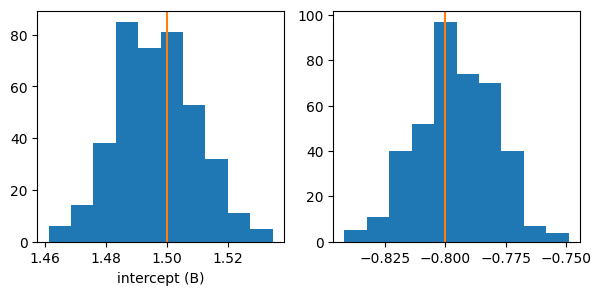

In [25]:
fig, (axa, axb) = plt.subplots(ncols=2, figsize=(7,3))

axa.hist(bestfit_a)
axa.axvline(A, color="tab:orange")
axa.set_xlabel("slope (A)")

axb.hist(bestfit_b)
axb.axvline(B, color="tab:orange")
axa.set_xlabel("intercept (B)")

axa.set_ylim(0)
axb.set_ylim(0)

In [26]:
### are the hessian -> cov error correcly estimated ?

In [27]:
bestfit_a.std()

Array(0.0132827, dtype=float32)

In [28]:
#cov_cc = jnp.linalg.inv(hess_pytree["coefs"]["coefs"] )
a_err, b_err = jnp.stack(jnp.sqrt(jnp.diag( cov ))[:2])
a_err, b_err

(Array(0.01368701, dtype=float32), Array(0.01541034, dtype=float32))

In [29]:
b_err / bestfit_b.std()

Array(0.9556369, dtype=float32)

In [30]:
a_err / bestfit_a.std()

Array(1.0304384, dtype=float32)

It seems so !